# Counts Heatmap

##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.9)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Functions

In [2]:
def rna_nms_table(df):
    npass = filter_df(df, "NMS Pass/Fail", "Pass")
    nfail = filter_df(df, "NMS Pass/Fail", "Fail")
    rpass = filter_df(df, "RNA Amp Pass/Fail", "Pass")
    rfail = filter_df(df, "RNA Amp Pass/Fail", "Fail")

    rfail_nfail = filter_df(rfail, "NMS Pass/Fail", "Fail")
    rfail_npass = filter_df(rfail, "NMS Pass/Fail", "Pass")
    rpass_nfail = filter_df(rpass, "NMS Pass/Fail", "Fail")
    rpass_npass = filter_df(rpass, "NMS Pass/Fail", "Pass")

    rfail_nfail["Group"] = "RNA Amp Fail/NMS Fail"
    rfail_npass["Group"] = "RNA Amp Fail/NMS Pass"
    rpass_nfail["Group"] = "RNA Amp Pass/NMS Fail"
    rpass_npass["Group"] = "RNA Amp Pass/NMS Pass"
    
    df = pd.concat([rfail_nfail, rfail_npass, rpass_nfail, rpass_npass])
    df["group_count"] = df.groupby(["Group", "Tree_call"])["Tree_call"].transform("count")
    df["group_total"] = df.groupby("Group")["Tree_call"].transform("count")
    df["proportion"] = df["group_count"] / df["group_total"] * 100
    return df

#### Paths/Fields

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [4]:
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]
region_list = ["FCx", "OCx", "PCx", "TCx"]

fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

##### Filtering shiny

In [5]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [6]:
shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace({True: "Pass", False: "Fail"})

In [7]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

In [8]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", "ri": "Input Resistance(MΩ)",
                       "sag" : "Sag Fraction", "tau": "τ(s)",
                       "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", "latency" : "Latency",
                       "f_i_curve_slope" : "F-I Curve"}, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


##### Human Layer 4 DF

In [9]:
h_l4 = filter_df(shiny_human, "layer", "L4")
h_l4 = create_cond_df(h_l4, "region", ["FCx", "OCx", "PCx", "TCx"]) #473 rows

merged = merge_dataframes(h_l4, ephys, "cell_name", "name", "inner") #379 rows
merged.dropna(subset=ephys_list, inplace=True) #311 rows

INFO:temp_funcs:Filtered dataframe based on layer == L4
INFO:temp_funcs:Created a conditional dataframe based on region containing ['FCx', 'OCx', 'PCx', 'TCx']
INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [10]:
d = dict()
for region_name in region_list:
    d[region_name] = filter_df(merged, "region", region_name)

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on region == OCx
INFO:temp_funcs:Filtered dataframe based on region == PCx
INFO:temp_funcs:Filtered dataframe based on region == TCx


In [14]:
count_rn

,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve,Group,group_count,group_total,proportion
308,PES4_190813_657_A01,H19.03.319.11.11.01.02,TCx_L4,0.360,Fail,10.114990,hIVSCC-MET,0.396362,Fail,Inh L4-5 PVALB MEPE,0.427598,GABAergic neuron,PVALB,PoorQ,TCx,L4,H19.03.319.11.11.01.02,-73.046080,137.843743,0.077345,9.645995,1.728833,0.02020,0.326737,RNA Amp Fail/NMS Fail,19,19,100.000000
309,P1S4_190514_003_A01,H19.03.311.14.06.01.02,TCx_L4,0.757,Fail,1.223222,hIVSCC-MET,0.381382,Fail,Exc L4-5 RORB FOLH1B,0.368181,Glutamatergic neuron,IT (L4-6),PoorQ,TCx,L4,H19.03.311.14.06.01.02,-60.559568,338.377386,0.230283,22.217731,3.623700,0.02246,0.293966,RNA Amp Fail/NMS Fail,19,19,100.000000
337,P1S4_190611_006_A01,H19.26.403.11.12.01.07,FCx_L4,0.348,Fail,7.841198,hIVSCC-MET,0.345571,Fail,Inh L1-3 SST CALB1,0.205165,Glutamatergic neuron,L5/6 CT,PoorQ,FCx,L4,H19.26.403.11.12.01.07,-69.113804,259.843826,0.113184,18.575962,2.542412,0.02656,0.302956,RNA Amp Fail/NMS Fail,19,19,100.000000
340,P2S4_180717_058_A01,H18.26.405.11.15.01.01,TCx_L4,0.525,Fail,7.502785,hIVSCC-MET,0.110688,Fail,Inh L2-4 PVALB WFDC2,0.810181,GABAergic neuron,PVALB,PoorQ,TCx,L4,H18.26.405.11.15.01.01,-62.262516,258.593738,0.076428,13.554698,1.996853,0.02050,0.448311,RNA Amp Fail/NMS Fail,19,19,100.000000
341,P2S4_180717_061_A01,H18.26.405.11.15.01.04,TCx_L4,0.196,Fail,4.487068,hIVSCC-MET,0.207101,Fail,Inh L2-4 PVALB WFDC2,0.548405,GABAergic neuron,LAMP5/PAX6/Other,PoorQ,TCx,L4,H18.26.405.11.15.01.04,-68.143510,197.656244,0.127995,14.422253,1.538046,0.01412,0.794764,RNA Amp Fail/NMS Fail,19,19,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,P8S4_180508_367_A01,H18.03.010.11.14.11,TCx_L4,0.626,Pass,25.572939,hIVSCC-MET,0.797138,Pass,Inh L2-4 PVALB WFDC2,0.941726,GABAergic neuron,PVALB,I3,TCx,L4,H18.03.010.11.14.11,-65.639094,85.000001,0.124616,8.414762,1.585645,0.01988,0.281675,RNA Amp Pass/NMS Pass,1,270,0.370370
319,PBS4_180717_513_A01,H18.03.313.11.21.01.01,TCx_L4,0.491,Pass,9.697907,hIVSCC-MET,0.418936,Pass,Exc L4-5 RORB FOLH1B,0.372023,Glutamatergic neuron,IT (L4-6),I2,TCx,L4,H18.03.313.11.21.01.01,-66.198831,216.406256,0.111654,21.796568,3.529272,0.02622,0.228571,RNA Amp Pass/NMS Pass,26,270,9.629630
322,PES4_191203_655_A01,H19.03.323.11.05.01.04,TCx_L4,0.465,Pass,9.328361,hIVSCC-MET,0.566989,Pass,Exc L4-5 RORB FOLH1B,0.530547,Glutamatergic neuron,IT (L4-6),PoorQ,TCx,L4,H19.03.323.11.05.01.04,-65.672618,251.294672,0.136424,33.828018,3.540821,0.04120,0.064935,RNA Amp Pass/NMS Pass,11,270,4.074074
350,P8S4_190122_357_A01,H19.03.302.11.06.01.03,TCx_L4,0.376,Pass,12.163754,hIVSCC-MET,0.416997,Pass,Exc L2-4 LINC00507 GLP2R,0.235294,Glutamatergic neuron,IT (L6),PoorQ,TCx,L4,H19.03.302.11.06.01.03,-67.994875,299.769670,0.043159,37.315644,4.877361,0.05932,0.123529,RNA Amp Pass/NMS Pass,11,270,4.074074


In [20]:
heatmap_df = count_rn.melt(id_vars=["subclass_label"],
                             value_vars="region",
                             var_name="ephys_features", value_name="%change from VISp")

In [21]:
heatmap_df

,subclass_label,ephys_features,%change from VISp
0,PVALB,region,TCx
1,IT (L4-6),region,TCx
2,L5/6 CT,region,FCx
3,PVALB,region,TCx
4,LAMP5/PAX6/Other,region,TCx
...,...,...,...
306,PVALB,region,TCx
307,IT (L4-6),region,TCx
308,IT (L4-6),region,TCx
309,IT (L6),region,TCx


In [22]:
heatmap_df = pd.pivot_table(heatmap_df, values='%change from VISp', index=["ephys_features"], columns="subclass_label")
heatmap_df

DataError: No numeric types to aggregate

##### Making groupby tables for RNA/NMS Groups

In [13]:
count_rn = rna_nms_table(merged)
count_fcx = rna_nms_table(d["FCx"])
count_tcx = rna_nms_table(d["TCx"])

INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopy

##### Tables

In [12]:
proportion_table = pd.pivot_table(count_tcx, values="proportion", index=["Group"], columns="Tree_call", fill_value=0)
count_table = pd.pivot_table(count_tcx, values="group_count", index=["Group"], columns="Tree_call", fill_value=0)

In [13]:
proportion_table

Tree_call,Core,I1,I2,I3,PoorQ
Group,,,,,
RNA Amp Fail/NMS Fail,0.000000,0.000000,0.000000,0.000000,100.000000
RNA Amp Fail/NMS Pass,25.000000,25.000000,0.000000,0.000000,50.000000
RNA Amp Pass/NMS Fail,7.142857,0.000000,0.000000,0.000000,92.857143
RNA Amp Pass/NMS Pass,68.750000,18.333333,8.333333,0.416667,4.166667


In [14]:
count_table

Tree_call,Core,I1,I2,I3,PoorQ
Group,,,,,
RNA Amp Fail/NMS Fail,0,0,0,0,17
RNA Amp Fail/NMS Pass,1,1,0,0,2
RNA Amp Pass/NMS Fail,1,0,0,0,13
RNA Amp Pass/NMS Pass,165,44,20,1,10


##### Plots 

In [15]:
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

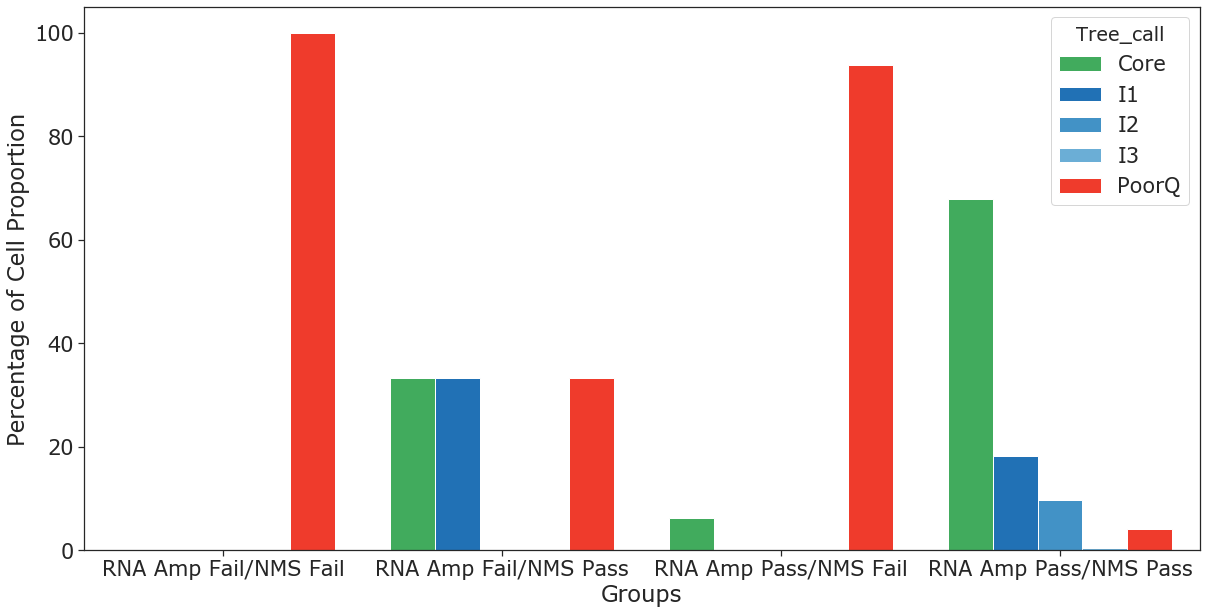

In [16]:
f, axes = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="Group", y="proportion", data=count_rn, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")
plt.xticks(rotation=0)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

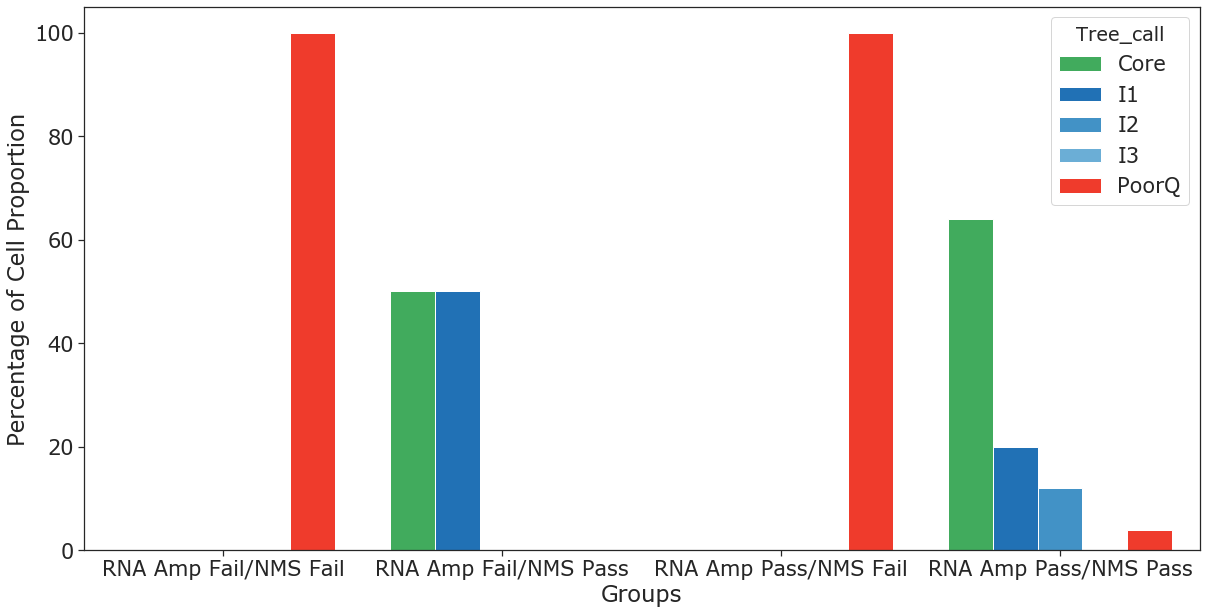

In [17]:
f, axes = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="Group", y="proportion", data=count_fcx, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")
plt.xticks(rotation=0)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

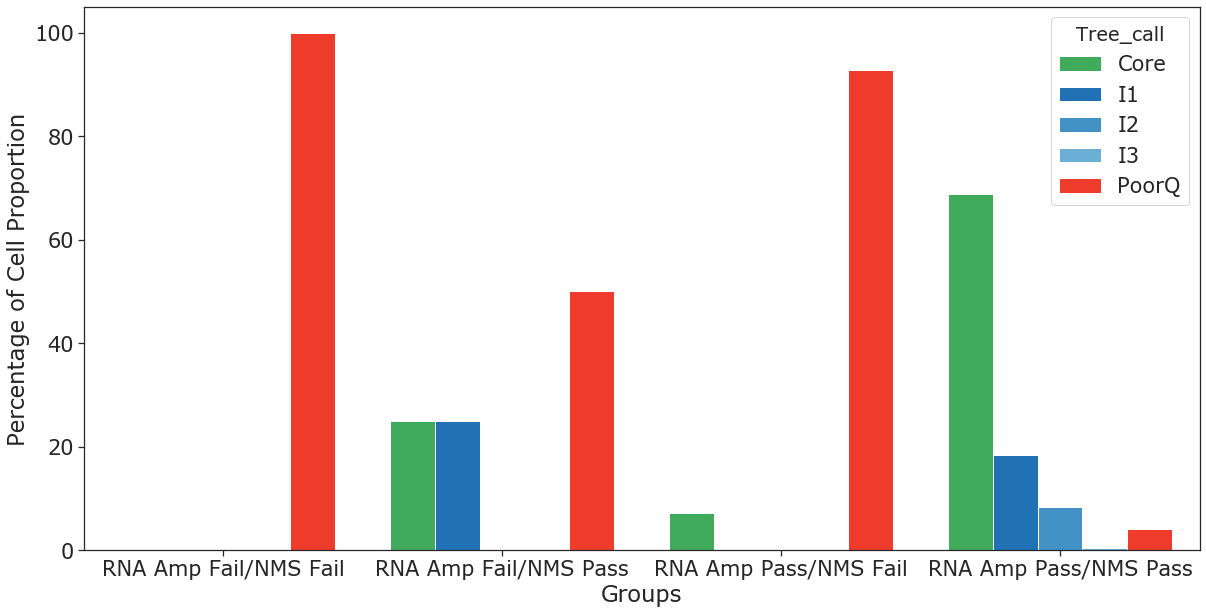

In [18]:
f, axes = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="Group", y="proportion", data=count_tcx, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Percentage of Cell Proportion")
plt.xticks(rotation=0)